<img src="images/datiaperti_small.png" />

# Geospatial Data Analysis - Vector Data
This notebook is about GDAL/OGR, a library for vector geospatial data formats used to traslate one format to another among those supported. GDAL is written in C/C++ with bindings in other languages such as Python and Java. GDAL also provides a set of programs that can be used from the command line. Install the gdal package before using this notebook  

$ conda install -c conda-forge gdal  

$ conda install -c conda-forge pyshp  

Use [GDAL/OGR Cookbook](https://pcjericks.github.io/py-gdalogr-cookbook/index.html) for references.

In [76]:
import os
import sys
import struct
import zipfile
from shapely import wkt, geometry
import fiona
import geopandas
import pyproj
import pandas as pd
import numpy as np
import utm
import shapefile as shp
from osgeo import gdal_array
from osgeo import ogr, osr
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import ospybook as pb
from ospybook.vectorplotter import VectorPlotter
vp = VectorPlotter(True)
%matplotlib inline

## Compressed files
### Zip

In [19]:
zip = open("data/census/GIS_CensusTract.zip", "rb")
zipShape = zipfile.ZipFile(zip)
for fileName in zipShape.namelist():
    out = open('data/census/' + fileName, "wb")
    out.write(zipShape.read(fileName))
    out.close()

## Vector Data
### Esri shape file
The Esri shapefile format has a fixed location and data type in the file header from byte 36 to byte 37 for the minimum x, minimum y, maximum x, and maximum y bounding box values.

In [20]:
path = os.path.relpath("data\stbnd\stbnd.shp")
f = open(path,"rb")
f.seek(36) 
struct.unpack("<d", f.read(8)) # min x

(318573.31825141667,)

In [21]:
struct.unpack("<d", f.read(8)) # min y

(1035233.9673716214,)

In [22]:
struct.unpack("<d", f.read(8)) # max x

(651004.9840024861,)

In [23]:
struct.unpack("<d", f.read(8)) # max y

(1577852.5200537047,)

### GeoJSON

In [24]:
gc = { "type": "GeometryCollection",
       "geometries": [
          { "type": "Point",
            "coordinates": [-89.33, 30.0]
          },
          { "type": "LineString",
            "coordinates": [ [-89.33, 30.30], [-89.36, 30.28] ]
          }
       ]
}

In [25]:
gc

{'type': 'GeometryCollection',
 'geometries': [{'type': 'Point', 'coordinates': [-89.33, 30.0]},
  {'type': 'LineString', 'coordinates': [[-89.33, 30.3], [-89.36, 30.28]]}]}

## Geospatial Python Toolbox
### Shapely
It is a generic geometry library

In [7]:
wktPoly = "POLYGON((0 0,4 0,4 4,0 4,0 0))" # a square on a 2D reference system
poly = wkt.loads(wktPoly)
poly.area

16.0

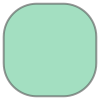

In [8]:
buf = poly.buffer(5.0)
buf

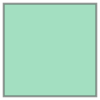

In [9]:
poly

### Fiona
A simple Python API around the OGR library for data access.

In [29]:
shp_file_name = "data/census/GIS_CensusTract_poly.shp"

In [30]:
f = fiona.open(shp_file_name)
f.driver

'ESRI Shapefile'

In [31]:
f.crs

{'init': 'epsg:4269'}

In [32]:
f.bounds # pairs of geo coordinates that define a bounding box) 

(-89.8744162216216, 30.161122135135138, -89.1383837783784, 30.661213864864862)

In [33]:
len(list(f)) # number of polygongs in the shape file

45

In [34]:
print(f[44])

{'type': 'Feature', 'id': '44', 'properties': OrderedDict([('GEODB_OID', 5014), ('OBJECTID', 5014), ('PERMANE0', '6c8bb2f3-c938-47af-8a5a-bfc238fa4dbc'), ('SOURCE_1', 'NA'), ('SOURCE_2', '20006'), ('SOURCE_3', 'Census Tracts'), ('SOURCE_4', 'Census Bureau'), ('DATA_SE5', '5'), ('DISTRIB6', 'E4'), ('LOADDATE', '2007-03-13'), ('QUALITY', '2'), ('SCALE', '1'), ('FCODE', '20200'), ('STCO_FI7', '28131'), ('STATE_NAME', '28'), ('COUNTY_8', '131'), ('CENSUST9', '28131020200'), ('POPULAT10', 10060), ('AREASQKM', 1136.80197235), ('GNIS_ID', 'NA'), ('POPULAT11', 10789), ('DB2GSE_12', 1136801972.35134), ('DB2GSE_13', 171767.00613302)]), 'geometry': {'type': 'Polygon', 'coordinates': [[(-89.34143044794058, 30.661213864864862), (-89.25635413513515, 30.661213864864862), (-89.24008407098594, 30.661213864864862), (-89.24008991712371, 30.654065012724942), (-89.24013591712377, 30.64764601271886), (-89.24214591712561, 30.647608012718823), (-89.24312391712654, 30.647590012718812), (-89.250050917133, 30.64

### GeoPandas

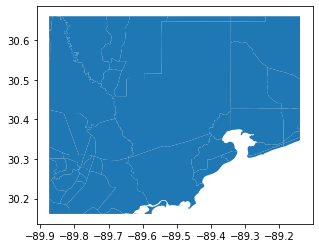

In [36]:
gdf = geopandas.GeoDataFrame
census = gdf.from_file("data/census/GIS_CensusTract_poly.shp")
census.plot()
plt.show()

In [37]:
r = shp.Reader(shp_file_name)
r.bbox # pairs of coordinates of two points used to define a bounding box (min_xm, min_y, max_x, max_y)

[-89.8744162216216, 30.161122135135138, -89.1383837783784, 30.661213864864862]

In [38]:
r.numRecords # number of polygons in the shape file

45

In [39]:
r.shapeType # 5 means polygons

5

In [40]:
[item[0] for item in r.fields[1:]] # record fields

['GEODB_OID',
 'OBJECTID',
 'PERMANE0',
 'SOURCE_1',
 'SOURCE_2',
 'SOURCE_3',
 'SOURCE_4',
 'DATA_SE5',
 'DISTRIB6',
 'LOADDATE',
 'QUALITY',
 'SCALE',
 'FCODE',
 'STCO_FI7',
 'STATE_NAME',
 'COUNTY_8',
 'CENSUST9',
 'POPULAT10',
 'AREASQKM',
 'GNIS_ID',
 'POPULAT11',
 'DB2GSE_12',
 'DB2GSE_13']

In [41]:
r.record(2)

Record #2: [4361, 4361, '614cc89a-a923-41ec-8d5c-f2b9b5dd97a3', 'NA', '20006', 'Census Tracts', 'Census Bureau', '5', 'E4', datetime.date(2007, 3, 13), '2', '1', '40102', '22103', '22', '103', '22103040102', 7506, 439.02573666, 'NA', 8161, 439025736.666308, 165912.198624811]

In [42]:
r.record(2)['SOURCE_4']

'Census Bureau'

## Raster data

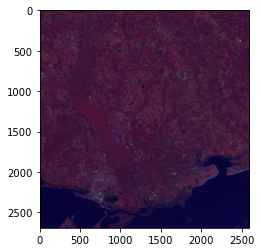

In [43]:
src = "FalseColor.tif"
im_orig = Image.open('images/FalseColor.tif')
plt.imshow(im_orig)
arr = gdal_array.LoadFile('images/' + src) # image loaded into a NumPy array

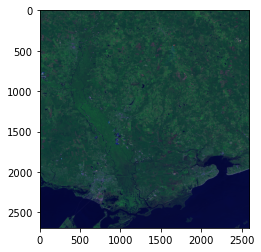

In [45]:
output = gdal_array.SaveArray(arr[[1, 0, 2], :], "images/swap.tif", format="GTiff", prototype=src) # change band order
im = Image.open('images/swap.tif')
plt.imshow(im)

### GDAL library

We use the OGR module to work with vector data. It provides a unique interface to read and write data in different formats such as Esri shape file, GeoJSON and many other. A dataset in OGR contains one layer that can contain one or more features. A layer also contains information such as the coordinate system that are used for the coordinates of the features. A feature is a geographic object: a point, a line or a polygon. A feature has attributes, one of this is its geometry. 

In [46]:
fn = r'data\global\ne_50m_populated_places.shp'
ds = ogr.Open(fn, 0) # open in read-only mode
if ds is None:
    sys.exit('Could not open {0}.'.format(fn))
layer = ds.GetLayer(0)
num_features = layer.GetFeatureCount()
i = 0
for feature in layer:  # a feature is a geographic object: a point, a line or a polygon.
    pt = feature.geometry()
    x = pt.GetX()
    y = pt.GetY()
    name = feature.GetField('NAME')
    pop = feature.GetField('POP_MAX')
    print(name, pop, x, y)
    i += 1
    if i == 10:
        break
del ds
print(num_features)

Bombo 75000 32.533299524864844 0.5832991056146284
Fort Portal 42670 30.27500161597942 0.671004121125236
Potenza 69060 15.798996495640267 40.642002130098206
Campobasso 50762 14.655996558921856 41.56299911864397
Aosta 34062 7.315002595706176 45.7370010670723
Mariehamn 10682 19.949004471869102 60.09699618489543
Ramallah 24599 35.206209378189556 31.90294475142406
Vatican City 832 12.453386544971766 41.903282179960115
Poitier 85960 0.3332765285345545 46.58329225573658
Clermont-Ferrand 233050 3.080008095928406 45.779982115759424
1249


We install the osgeopy module from C. Garrard GitHub [repository](https://github.com/cgarrard/osgeopy-code)

In [47]:
pb.print_attributes(fn, 10, ['NAME', 'POP_MAX'])

FID    Geometry                  NAME                POP_MAX    
0      POINT (32.533, 0.583)     Bombo               75000      
1      POINT (30.275, 0.671)     Fort Portal         42670      
2      POINT (15.799, 40.642)    Potenza             69060      
3      POINT (14.656, 41.563)    Campobasso          50762      
4      POINT (7.315, 45.737)     Aosta               34062      
5      POINT (19.949, 60.097)    Mariehamn           10682      
6      POINT (35.206, 31.903)    Ramallah            24599      
7      POINT (12.453, 41.903)    Vatican City        832        
8      POINT (0.333, 46.583)     Poitier             85960      
9      POINT (3.080, 45.780)     Clermont-Ferrand    233050     
10 of 1249 features


Plot the data

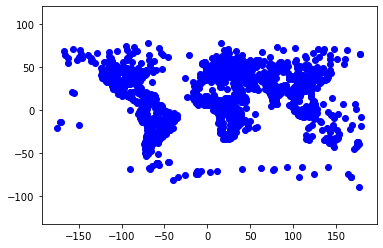

In [14]:
vp.plot(r'data\global\ne_50m_populated_places.shp', 'bo')

Print the west and east longitude and the south and nord latitude of the bounding box that contains all the features in the a layer.

In [49]:
ds = ogr.Open(r'data\Washington\large_cities.geojson')
layer = ds.GetLayer(0)
extent = layer.GetExtent()
print(extent)

(-122.66148376464844, -117.4260482788086, 45.638729095458984, 48.759552001953125)


We can read the layer's coordinate system that is used by the features

In [50]:
print(layer.GetSpatialRef())

GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101,
            AUTHORITY["EPSG","7019"]],
        AUTHORITY["EPSG","6269"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]


We print the attributes (fields) used for the features

In [51]:
for field in layer.schema:
    print(field.name, field.GetTypeName())

CITIESX020 Integer
FEATURE String
NAME String
POP_RANGE String
POPULATION Integer
FIPS55 String
COUNTY String
FIPS String
STATE String
STATE_FIPS String
DISPLAY Integer


Let's see the 1st feature's type of the layer

In [52]:
feature0 = layer.GetFeature(0)
print(feature0.geometry().GetGeometryName())

POINT


now we can close the datasource

In [53]:
del ds

We create a new shape file copying the structure of another shape file.

In [55]:
ds = ogr.Open(r'data\global\ne_50m_populated_places.shp', 1)
if ds is None:
    sys.exit('Could not open folder.')
in_lyr = ds.GetLayer()
#for field in in_lyr.schema:
#    print(field.name, field.GetTypeName())

In [56]:
if ds.GetLayer('capital_cities'):
    ds.DeleteLayer('capital_cities')
out_lyr = ds.CreateLayer('capital_cities', in_lyr.GetSpatialRef(), ogr.wkbPoint)
out_lyr.CreateFields(in_lyr.schema)
out_defn = out_lyr.GetLayerDefn()
out_feat = ogr.Feature(out_defn)
for in_feat in in_lyr:
    if in_feat.GetField('FEATURECLA') == 'Admin-0 capital':
        geom = in_feat.geometry()
        out_feat.SetGeometry(geom)
        for i in range(in_feat.GetFieldCount()):
            value = in_feat.GetField(i)
            out_feat.SetField(i, value)
        out_lyr.CreateFeature(out_feat)

We save the data by closing the datasource

In [57]:
del ds

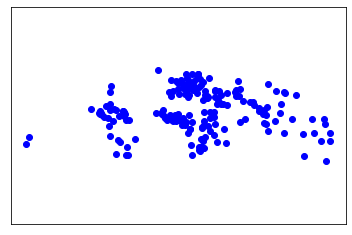

In [52]:
vp = VectorPlotter(True)
vp.plot(r'data\global\capital_cities.shp', 'bo')

### Creating a new data source
We can create new data sources in any format for which a driver is available in OGR.

In [59]:
json_driver = ogr.GetDriverByName('GeoJSON')
json_fn = r'data\global\my_datasource.json'
if os.path.exists(json_fn):
    json_driver.DeleteDataSource(json_fn)
json_ds = json_driver.CreateDataSource(json_fn)
srs = ogr.osr.SpatialReference()
srs.ImportFromEPSG(32632)
if json_ds is None:
    sys.exit('Could not create {0}.'.format(json_fn))
layer = json_ds.CreateLayer('capital_cities', srs, ogr.wkbPoint)

In [60]:
coord_fld = ogr.FieldDefn('X', ogr.OFTReal)
coord_fld.SetWidth(8)
coord_fld.SetPrecision(3)
layer.CreateField(coord_fld)
coord_fld.SetName('Y')
layer.CreateField(coord_fld)

0

In [61]:
for field in layer.schema:
    print(field.name, field.GetTypeName())
#del json_ds

X Real
Y Real


In [62]:
layer_def = layer.GetLayerDefn()
layer_def.GetFieldCount()

2

In [63]:
feat = ogr.Feature(layer_def)
feat.SetField(0, 1.2)
feat.SetField(1, 3.6)
feat.SetGeometry(ogr.wkbPoint)
layer.CreateFeature(feat)

TypeError: in method 'Feature_SetGeometry', argument 2 of type 'OGRGeometryShadow *'

In [64]:
layer.GetFeatureCount()

0

### Vector file formats
We define a function that will print the layers contained in a data source using its file name as input argument.

In [65]:
def print_layers(fn):
    ds = ogr.Open(fn, 0)
    if ds is None:
        raise OSError('Could not open {}'.format(fn))
    for i in range(ds.GetLayerCount()):
        layer = ds.GetLayer(i)
        print('{0}: {1}'.format(i, layer.GetName()))

An Esri shape file can contain only one layer

In [66]:
fn = r'data\global\ne_50m_populated_places.shp'
print_layers(fn)

0: ne_50m_populated_places


An SQLite database can contain several layers

In [67]:
fn = r'data\global\natural_earth_50m.sqlite'
print_layers(fn)

0: countries
1: populated_places


In [68]:
ds = ogr.Open(fn)
pp_layer = ds.GetLayer('populated_places')

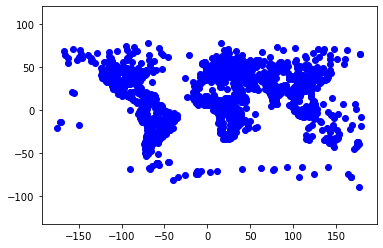

In [69]:
vp.plot(pp_layer, 'bo')

ESRI shape files can be stored in a folder. Each shape file defines a layer. 

In [70]:
fn = r'data\US'
print_layers(fn)

0: citiesx020
1: cities_48
2: cities_albers
3: countyp010
4: roadtrl020
5: statep010
6: states_48
7: us_volcanos
8: us_volcanos_albers
9: volcanx020
10: wtrbdyp010


CSV files in a folder can be used to represent different layers.

In [71]:
fn = r'data\US\csv'
print_layers(fn)

0: cities
1: volcanoes


ESRI file geodatabase

In [72]:
fn = r'data\global\natural_earth.gdb'
print_layers(fn)

0: countries_10m
1: populated_places_10m
2: countries_110m
3: populated_places_110m


In [73]:
ds = ogr.Open(fn)
layer = ds.GetLayer('countries_10m')

We copy a layer from an ESRI geodatabase to a shape file.

In [74]:
gdb_ds = ogr.Open(r'data\global\natural_earth.gdb')
gdb_lyr = gdb_ds.GetLayerByName('countries_110m')
shp_ds = ogr.Open(r'data\global', 1)
shp_ds.CopyLayer(gdb_lyr, 'copy_countries_110m')
del shp_ds, gdb_ds

### Filtering data with OGR
We use the OGR library to filter features in a data source, e.g. a shapefile.

In [75]:
ds = ogr.Open(r'data\global')
country_layer = ds.GetLayer('ne_50m_admin_0_countries')
pb.print_attributes(country_layer, 4, ['name','continent'], geom=True)

FID    Geometry        name           continent        
0      POLYGON         Aruba          North America    
1      POLYGON         Afghanistan    Asia             
2      MULTIPOLYGON    Angola         Africa           
3      POLYGON         Anguilla       North America    
4 of 241 features


In [77]:
#for field in country_layer.schema:
#    print(field.name, field.GetTypeName())

### Attribute filtering
We select some features by one of their attibutes.

In [78]:
country_layer.SetAttributeFilter("continent = 'Asia'")

0

In [79]:
country_layer.GetFeatureCount()

53

In [80]:
pb.print_attributes(country_layer, 5, ['name', 'continent'], geom=False)

FID    name                    continent    
1      Afghanistan             Asia         
7      United Arab Emirates    Asia         
9      Armenia                 Asia         
17     Azerbaijan              Asia         
22     Bangladesh              Asia         
5 of 53 features


In [81]:
country_layer.GetFeature(7).GetField('name')

'United Arab Emirates'

In [82]:
country_layer.SetAttributeFilter("continent = 'South America'")

0

In [83]:
country_layer.GetFeatureCount()

13

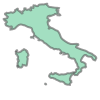

In [84]:
country_layer.SetAttributeFilter("name = 'Italy'")
feat = country_layer.GetNextFeature()
country = feat.geometry().Clone()
wkt.loads(country.ExportToIsoWkt())


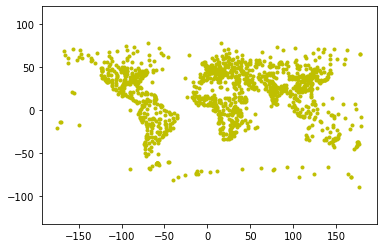

In [85]:
city_layer = ds.GetLayer('ne_50m_populated_places')
city_layer.GetFeatureCount()
vp.plot(city_layer, 'y.')

### Spatial filtering
We select the cities that lie within a country's boundary

In [81]:
city_layer.SetSpatialFilter(country) # set the spatial filter
city_layer.GetFeatureCount()

4

In [ ]:
#for field in city_layer.schema:
#    print(field.name, field.GetTypeName())

We can see that since the Vatican City is within the Italian boundary it is also in the list of the spatially filtered cities

In [70]:
pb.print_attributes(city_layer, 0, ['NAME', 'ADM0NAME', 'POP2010'], geom=False)

FID     NAME            ADM0NAME              POP2010    
2       Potenza         Italy                 0.0        
3       Campobasso      Italy                 0.0        
4       Aosta           Italy                 0.0        
7       Vatican City    Vatican (Holy Sea)    0.0        
20      Bologna         Italy                 0.0        
21      Cagliari        Italy                 0.0        
22      Catanzaro       Italy                 0.0        
23      Bari            Italy                 0.0        
24      L'Aquila        Italy                 0.0        
25      Ancona          Italy                 0.0        
26      Perugia         Italy                 0.0        
27      Trieste         Italy                 0.0        
28      Trento          Italy                 0.0        
97      Turin           Italy                 1652.0     
110     Genoa           Italy                 0.0        
412     Florence        Italy                 0.0        
413     Catani

We can further select the cities by attributes, e.g. by their population

In [78]:
city_layer.SetAttributeFilter('POP2010 > 1000')
city_layer.GetFeatureCount()

4

In [80]:
pb.print_attributes(city_layer, 0, ['NAME', 'ADM0NAME', 'POP2010'], geom=False)

FID     NAME      ADM0NAME    POP2010    
97      Turin     Italy       1652.0     
1107    Naples    Italy       2250.0     
1108    Milan     Italy       2945.0     
1232    Rome      Italy       3339.0     
4 of 4 features


We can use a bounding box to spatially filter the features. We remove the attribute filter than we apply a spatial filter using a bounding box

In [88]:
city_layer.SetAttributeFilter(None)
city_layer.SetSpatialFilter(None)
min_long = 6.671
min_lat = 35.494
max_long = 18.337
max_lat = 47.095
city_layer.SetSpatialFilterRect(min_long, min_lat, max_long, max_lat)
pb.print_attributes(city_layer, 0, ['NAME', 'ADM0NAME', 'POP2010'], geom=False)

FID     NAME            ADM0NAME                  POP2010    
2       Potenza         Italy                     0.0        
3       Campobasso      Italy                     0.0        
4       Aosta           Italy                     0.0        
7       Vatican City    Vatican (Holy Sea)        0.0        
20      Bologna         Italy                     0.0        
21      Cagliari        Italy                     0.0        
22      Catanzaro       Italy                     0.0        
23      Bari            Italy                     0.0        
24      L'Aquila        Italy                     0.0        
25      Ancona          Italy                     0.0        
26      Perugia         Italy                     0.0        
27      Trieste         Italy                     0.0        
28      Trento          Italy                     0.0        
34      Ajaccio         France                    0.0        
44      Banja Luka      Bosnia and Herzegovina    0.0        
48      

Then we apply an attribute filter to select the cities with a population above 1 million.

In [91]:
city_layer.SetAttributeFilter('POP2010 > 1000')
pb.print_attributes(city_layer, 0, ['NAME', 'ADM0NAME', 'POP2010'], geom=False)

FID     NAME      ADM0NAME    POP2010    
97      Turin     Italy       1652.0     
1107    Naples    Italy       2250.0     
1108    Milan     Italy       2945.0     
1232    Rome      Italy       3339.0     
4 of 4 features


### SQL spatial and attribute filtering
We filter cities by two attributes and then by a geometry. In particular we select cities that have a population above 1 million and lie withing the Italian boundary.

In [89]:
ds = ogr.Open(r'data\global')
country_layer = ds.GetLayer('ne_50m_admin_0_countries')
country_layer.SetAttributeFilter("name = 'Italy'")
feat = country_layer.GetNextFeature()
country = feat.geometry().Clone() # we use a country's geometry for spatial filtering
sql = "SELECT NAME, POP2010 FROM ne_50m_populated_places WHERE POP2010 > 1000 ORDER BY POP2010 DESC"
layer = ds.ExecuteSQL(sql, country)
pb.print_attributes(layer)

FID     Geometry                  NAME      POP2010    
1232    POINT (12.481, 41.898)    Rome      3339.0     
1108    POINT (9.203, 45.472)     Milan     2945.0     
1107    POINT (14.243, 40.842)    Naples    2250.0     
97      POINT (7.668, 45.072)     Turin     1652.0     
4 of 4 features


### Reading ESRI shape files using the Python Shapefile Library

In [109]:
shp_path = r'data\esri\World_Countries\World_Countries'
sf = shp.Reader(shp_path)
len(sf)

249

In [110]:
sf.shapeType

5

In [111]:
shapes = sf.shapes(); len(shapes)

249

In [112]:
print(sf)

shapefile Reader
    249 shapes (type 'POLYGON')
    249 records (8 fields)


In [113]:
sf.shapeType == shapefile.POLYGON

True

In [114]:
s = sf.shape(7)
['%.3f' % coord for coord in s.bbox]

['-171.863', '-9.219', '-171.844', '-9.171']

In [115]:
rec = sf.record(3)
rec[1:3]

['French Polynesia', 'PF']

In [116]:
sf.fields

[('DeletionFlag', 'C', 1, 0),
 ['FID', 'N', 3, 0],
 ['COUNTRY', 'C', 40, 0],
 ['ISO', 'C', 2, 0],
 ['COUNTRYAFF', 'C', 32, 0],
 ['AFF_ISO', 'C', 2, 0],
 ['SHAPE_Leng', 'N', 24, 15],
 ['SHAPE_Area', 'N', 24, 15]]

In [117]:
sf.records()

[Record #0: [1, 'American Samoa', 'AS', 'United States', 'US', 0.600124358526115, 0.013719718651009],
 Record #1: [2, 'United States Minor Outlying Islands', 'UM', 'United States', 'US', 0.480216329338853, 0.003216016346711],
 Record #2: [3, 'Cook Islands', 'CK', 'New Zealand', 'NZ', 0.980664163809754, 0.013073457998731],
 Record #3: [4, 'French Polynesia', 'PF', 'France', 'FR', 3.930210621828431, 0.175332140034676],
 Record #4: [5, 'Niue', 'NU', 'New Zealand', 'NZ', 0.54141251184954, 0.021413763180365],
 Record #5: [6, 'Pitcairn', 'PN', 'United Kingdom', 'GB', 0.338167133312508, 0.004286042985784],
 Record #6: [7, 'Samoa', 'WS', 'Samoa', 'WS', 3.019661894193636, 0.245518905956019],
 Record #7: [8, 'Tokelau', 'TK', 'New Zealand', 'NZ', 0.108696103738711, 0.000606214247967],
 Record #8: [9, 'Tonga', 'TO', 'Tonga', 'TO', 1.309123787883922, 0.040018203653503],
 Record #9: [10, 'Wallis and Futuna', 'WF', 'France', 'FR', 0.700607552306367, 0.01341437160995],
 Record #10: [11, 'El Salvador',

In [118]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [120]:
df = read_shapefile(sf)
df.shape

(249, 8)

In [121]:
df.sample(5)

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,coords
115,116,British Indian Ocean Territory,IO,United Kingdom,GB,0.849597,0.007405,"[(72.43253609500005, -7.434735941999975), (72...."
192,193,Bahrain,BH,Bahrain,BH,1.653726,0.057735,"[(50.59304508100007, 26.150826986000027), (50...."
46,47,Guyana,GY,Guyana,GY,25.707599,17.175215,"[(-58.17261792099998, 6.81221811000006), (-58...."
134,135,Nigeria,NG,Nigeria,NG,48.108082,74.887642,"[(11.799436054000068, 7.29666411900007), (11.7..."
102,103,Kenya,KE,Kenya,KE,33.612679,47.306852,"[(33.921100151000076, -1.001945927999941), (33..."


In [124]:
df.COUNTRY

0                            American Samoa
1      United States Minor Outlying Islands
2                              Cook Islands
3                          French Polynesia
4                                      Niue
                       ...                 
244                Northern Mariana Islands
245                                   Palau
246                      Russian Federation
247                                   Spain
248                                Canarias
Name: COUNTRY, Length: 249, dtype: object

In [127]:
df[df.COUNTRY == 'Italy']

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,coords
170,171,Italy,IT,Italy,IT,68.044301,33.055064,"[(12.753573241000026, 43.971000117000074), (12..."


### Plotting a map from a shapefile
based on [this post](https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f)

In [122]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

In [143]:
country = 'Italy'
country_id = df[df.COUNTRY == country]; country_id.index[0]
type(country_id.index[0])

numpy.int64

(-52.46122876466079, -9.175039980656539)

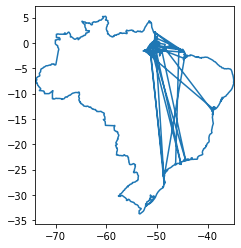

In [153]:
plot_shape(20, s=None)

In [154]:
sf.shape(170)

In [155]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

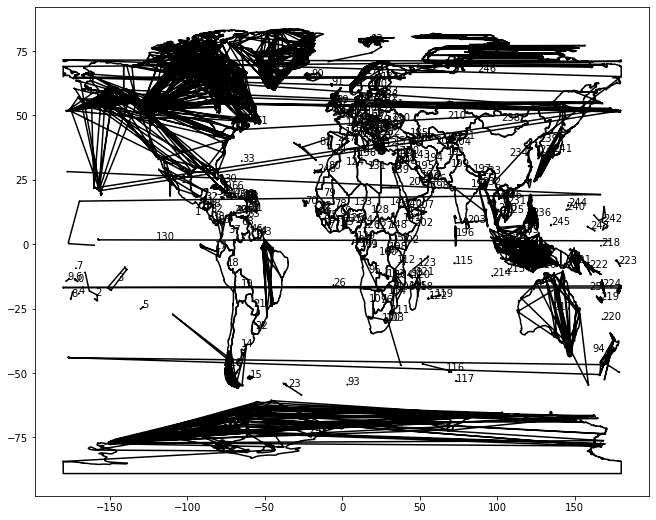

In [156]:
plot_map(sf)

## Manipulating geometries with OGR
We want to represent a house with a small garden and other features. We start by representing some features as points. A point feature has a geometry and attributes such as the coordinates. A point can have only one pair of coordinates.

### Point geometry

In [6]:
firepit = ogr.Geometry(ogr.wkbPoint)
firepit.AddPoint(59.5, 11.5)
x, y = firepit.GetX(), firepit.GetY(); x, y

(59.5, 11.5)

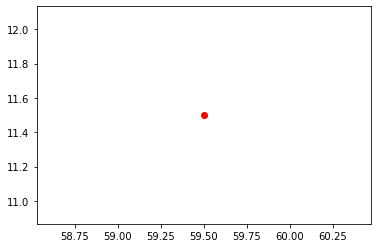

In [15]:
vp.plot(firepit, 'ro') # print the point as a red dot (ro)

### Multipoint geometry
A multipoint geometry is a collection of points that are associated to a feature.

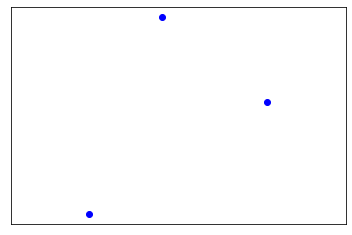

In [24]:
vp.clear()
faucets = ogr.Geometry(ogr.wkbMultiPoint)
faucet = ogr.Geometry(ogr.wkbPoint)
faucet.AddPoint(67.5, 16)
faucets.AddGeometry(faucet)
faucet.AddPoint(73, 31)
faucets.AddGeometry(faucet)
faucet.AddPoint(81, 24.5)
faucets.AddGeometry(faucet)
vp.plot(faucets, 'bo')

### Line
A line has a geometry to which two or more points are added.

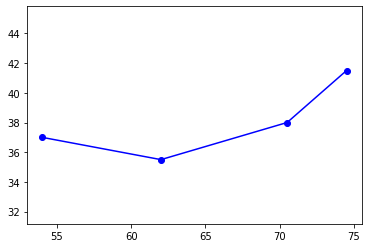

In [34]:
sidewalk = ogr.Geometry(ogr.wkbLineString)
sidewalk.AddPoint(54, 37)
sidewalk.AddPoint(62, 35.5)
sidewalk.AddPoint(70.5, 38)
sidewalk.AddPoint(74.5, 41.5)
vp.plot(sidewalk, 'b-o')

In [35]:
vertices = sidewalk.GetPoints()
print(vertices)

[(54.0, 37.0, 0.0), (62.0, 35.5, 0.0), (70.5, 38.0, 0.0), (74.5, 41.5, 0.0)]


In [36]:
vertices[2:2] = [(66.5, 35)]
print(vertices)

[(54.0, 37.0, 0.0), (62.0, 35.5, 0.0), (66.5, 35), (70.5, 38.0, 0.0), (74.5, 41.5, 0.0)]


### Multiline
A multiline is a collection of lines.

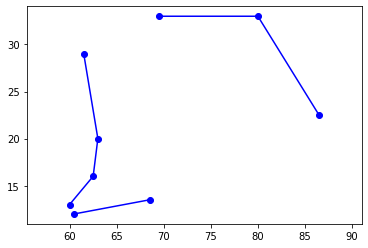

In [38]:
line1 = ogr.Geometry(ogr.wkbLineString)
line1.AddPoint(61.5, 29)
line1.AddPoint(63, 20)
line1.AddPoint(62.5, 16)
line1.AddPoint(60, 13)
line2 = ogr.Geometry(ogr.wkbLineString)
line2.AddPoint(60.5, 12)
line2.AddPoint(68.5, 13.5)
line3 = ogr.Geometry(ogr.wkbLineString)
line3.AddPoint(69.5, 33)
line3.AddPoint(80, 33)
line3.AddPoint(86.5, 22.5)
multiline = ogr.Geometry(ogr.wkbMultiLineString)
multiline.AddGeometry(line1)
multiline.AddGeometry(line2)
multiline.AddGeometry(line3)
vp.plot(multiline, 'b-o')

### Polygon
A polygon can have one or more closed paths, also called ring. This happens because a polygon can have a hole that can be represented by another polygon inside the first one.

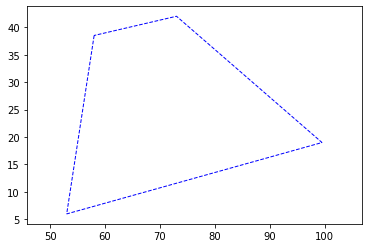

In [47]:
ring = ogr.Geometry(ogr.wkbLinearRing)
ring.AddPoint(58, 38.5)
ring.AddPoint(53, 6)
ring.AddPoint(99.5, 19)
ring.AddPoint(73, 42)
yard = ogr.Geometry(ogr.wkbPolygon)
yard.AddGeometry(ring)
yard.CloseRings()
vp.plot(yard, fill=False, edgecolor='blue', linestyle='dashed')

### Polygon with hole
A polygon with holes is a geometry made up of one external polygon, for the external border, and one or more other polygons inside it for the internal borders. As an example we will add a closed path, a house, to the polygon that we have already created.

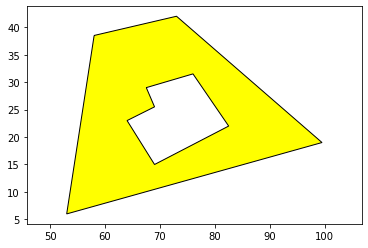

In [48]:
house = ogr.Geometry(ogr.wkbLinearRing)
house.AddPoint(67.5, 29)
house.AddPoint(69, 25.5)
house.AddPoint(64, 23)
house.AddPoint(69, 15)
house.AddPoint(82.5, 22)
house.AddPoint(76, 31.5)
yard.AddGeometry(house)
yard.CloseRings()
vp.plot(yard, 'yellow')

## Vector analysis with OGR
In this section we use topological operators available from OGR.

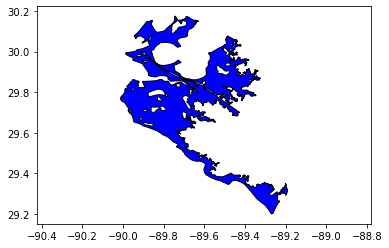

In [31]:
water_ds = ogr.Open(r'data\US\wtrbdyp010.shp')
water_layer = water_ds.GetLayer(0)
water_layer.SetAttributeFilter('WaterbdyID = 1011327')
marsh_feature = water_layer.GetNextFeature()
marsh_geometry = marsh_feature.geometry().Clone()
vp.plot(marsh_geometry, 'b')

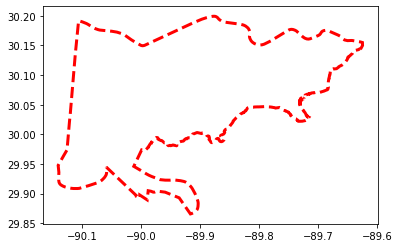

In [32]:
nola_ds = ogr.Open(r'data\Louisiana\NOLA.shp')
nola_layer = nola_ds.GetLayer(0)
nola_feature = nola_layer.GetNextFeature()
nola_geometry = nola_feature.geometry().Clone()
vp.plot(nola_geometry, fill=False, ec='red', ls='dashed', lw=3)

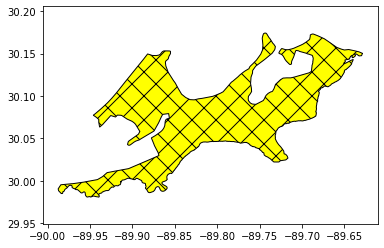

In [33]:
intersection = marsh_geometry.Intersection (nola_geometry)
vp.plot(intersection, 'yellow', hatch='x')

In [34]:
water_layer.SetAttributeFilter("Feature != 'Lake'")
water_layer.SetSpatialFilter(nola_geometry)
wetlands_area = 0
for feature in water_layer:
    intersect = feature.geometry().Intersection (nola_geometry)
    wetlands_area += intersect.GetArea()
pcnt = wetlands_area / nola_geometry.GetArea()
print('{:.1%} of New Orleans is wetland'.format(pcnt))

28.7% of New Orleans is wetland


A different way to get the same result (but it doesn't seem to work)

In [35]:
water_layer.SetAttributeFilter("Feature != 'Lake'")
memory_driver = ogr.GetDriverByName('Memory')
temp_ds = memory_driver.CreateDataSource('temp')
temp_layer = temp_ds.CreateLayer('temp')
nola_layer.Intersection(water_layer, temp_layer)
sql = 'SELECT SUM(OGR_GEOM_AREA) AS area FROM temp'
layer = temp_ds.ExecuteSQL (sql)
pcnt = layer.GetFeature(0).GetField('area') / nola_geometry.GetArea()
print('{:.1%} of New Orleans is wetland'.format(pcnt))

7910.9% of New Orleans is wetland


### Proximity tools
We want to know how many US cities lie within a certain distance from volcanos. We begin by opening a layer about the US cities and a layer about volcanos in the US.

In [95]:
shp_ds = ogr.Open(r'data\US')
volcano_layer = shp_ds.GetLayer('us_volcanos_albers')
cities_layer = shp_ds.GetLayer('cities_albers')
print('Cities: {}'.format(cities_layer.GetFeatureCount()))
print('Volcanos: {}'.format(volcano_layer.GetFeatureCount()))

Cities: 35432
Volcanos: 155


We need a layer that will contain the volcanos with a buffer area around them. The layer will be in memory since we need it only to compute the number of cities that lie within the buffer area of a volcano.

In [80]:
memory_driver = ogr.GetDriverByName('memory')
memory_ds = memory_driver.CreateDataSource('temp')
buffer_layer = memory_ds.CreateLayer('buffer')
buffer_feature = ogr.Feature(buffer_layer.GetLayerDefn())

We extract the volcanos' geometries, compute the buffer areas around them and we add those buffer areas to the temporary layer

In [81]:
distance = 16000 # 1 mile
for volcano_feature in volcano_layer:
    buffer_geometry = volcano_feature.geometry().Buffer(distance)
    buffer_feature.SetGeometry(buffer_geometry)
    buffer_layer.CreateFeature(buffer_feature)

We need another temporary (in memory) layer to store the result of the intersection between the volcanos with their buffer areas and the cities to know how many of the latter lie within a volcano.

In [82]:
result_layer = memory_ds.CreateLayer('result')
buffer_layer.Intersection (cities_layer, result_layer)

0

In [83]:
print('Cities: {}'.format(result_layer.GetFeatureCount()))

Cities: 83


We can perform the same task following a different approach. We use a multipolygon to store all the volcanos' buffer geometries, then we apply a method, UnionCascaded, to create the union of the volcano buffer areas to be used as a filter for cities.

In [87]:
volcano_layer.ResetReading()
multipoly = ogr.Geometry(ogr.wkbMultiPolygon)

for volcano_feature in volcano_layer:
    buffer_geometry = volcano_feature.geometry().Buffer(distance)
    multipoly.AddGeometry(buffer_geometry)

cities_layer.SetSpatialFilter(multipoly.UnionCascaded ())
print('Cities: {}'.format(cities_layer.GetFeatureCount()))

Cities: 78


As we can see, the number of cities is lower with this second method. This happens because with the first method some cities lie within more than one volcano buffer area and so they are counted more than once.

Now we look for the Mount St. Helens nearest city and we compute its distance from the volcano

In [111]:
distance = 32000 # 20 miles
volcano_layer.SetAttributeFilter("NAME = 'St. Helens'")
feature = volcano_layer.GetNextFeature()
st_helens = feature.geometry().Clone()
buffer_geometry = st_helens.Buffer(distance)
cities_layer.SetSpatialFilter(buffer_geometry)
print('Cities: {}'.format(cities_layer.GetFeatureCount()))

Cities: 1


In [110]:
feature_city = cities_layer.GetNextFeature()
name = feature_city.GetField('NAME')
print(name)

Cougar


In [114]:
meters = round(st_helens.Distance(feature_city.geometry().Clone()))
miles = meters / 1600
print('{} meters ({} miles)'.format(meters, miles))

18920 meters (11.825 miles)


### Suitability analysis: locating areas suitable for wind farms
We look for areas suitable for wind farms. These areas must satisfy two criteria: 

1. be classified as 3 or more for wind
2. population density less than 0.5 persons per square kilometer.

First we get the population density from the 'popsqkm' field of the California census data. 

In [2]:
census_fn = r'data\California\ca_census_albers.shp'
census_ds = ogr.Open(census_fn, True)
census_layer = census_ds.GetLayer()
#for row in census_layer:
#    popsqkm = row.GetField('popsqkm')
#    print('Population density: {} persons/sqkm'.format(popsqkm))

2nd, we get the geometry of the Imperial county for which we want to assess the suitabilty for wind farms.

In [3]:
county_fn = r'data\US\countyp010.shp'
county_ds = ogr.Open(county_fn)
county_layer = county_ds.GetLayer()
county_layer.SetAttributeFilter("COUNTY ='Imperial County'")
feat = county_layer.GetNextFeature()
county_geom = feat.geometry().Clone()
del county_ds

We have to project the county data onto the same reference system used for the census data, then we can spatially filter the census data to get the Imperial county census data to finally select the areas with a population density below 0.5 persons per square meter.

In [4]:
county_geom.TransformTo(census_layer.GetSpatialRef())
census_layer.SetSpatialFilter(county_geom)
census_layer.SetAttributeFilter('popsqkm < 0.5')
census_layer.GetFeatureCount()

2

Now we get the wind data filtering the areas that are classified 3 or above

In [5]:
wind_fn = r'data\California\california_50m_wind_albers.shp'
wind_ds = ogr.Open(wind_fn)
wind_layer = wind_ds.GetLayer()
wind_layer.SetAttributeFilter('WPC >= 3')
wind_layer.GetFeatureCount()

124244

Before applying the two filters for our suitability assessment we create a new data source (Esri shapefile) where we will store the results. The data source has two attributes: wind and popsqkm.

In [6]:
suitability_fn = r'data\California\wind_farm.shp'
suitability_ds = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(suitability_fn)
suitability_layer = suitability_ds.CreateLayer('wind_farm', wind_layer.GetSpatialRef(), ogr.wkbPolygon)
suitability_layer.CreateField(ogr.FieldDefn('wind', ogr.OFTInteger))
suitability_layer.CreateField(ogr.FieldDefn('popsqkm', ogr.OFTReal))
suitability_row = ogr.Feature(suitability_layer.GetLayerDefn())

We iterate through the areas that meet the suitability criteria saving the data in the suitability data source

In [20]:
for census_row in census_layer:
    census_geom = census_row.geometry()
    census_geom = census_geom.Intersection(county_geom)
    wind_layer.SetSpatialFilter(census_geom)
    print('Intersecting census tract with {0} wind polygons'.format(wind_layer.GetFeatureCount()))
    if wind_layer.GetFeatureCount() > 0:
        suitability_row.SetField('popsqkm', census_row.GetField('popsqkm'))
        for wind_row in wind_layer:
            wind_geom = wind_row.geometry()
            is_intersect = census_geom.Intersect(wind_geom)
            if is_intersect:
                suitability_row.SetField('wind', wind_row.GetField('WPC'))
                suitability_row.SetGeometry(census_geom.Intersection(wind_geom))
                suitability_layer.CreateFeature(suitability_row)
# del suitability_ds

Intersecting census tract with 36 wind polygons
Intersecting census tract with 957 wind polygons


In [17]:
# pb.print_attributes(suitability_layer, 0, ['wind', 'popsqkm'], geom=False)

In [21]:
suitability_layer.GetFeatureCount()

2979

### Tracking animals: Galapagos albatrosses
In this example we use a dataset from a [research study](https://www.datarepository.movebank.org/handle/10255/move.331) that contains data about the movements of albatrosses between the Galapagos islands and the coast of Peru. The original dataset is a CSV file. We will first create a shapefile with a spatial reference system and two attributes, tag_id and timestamp, then we will copy the data from the CSV file to the shapefile.

In [2]:
shp_fn = r"data\Galapagos\albatross_dd.shp"
shp_ds = ogr.GetDriverByName('ESRI Shapefile').CreateDataSource(shp_fn)
sr = osr.SpatialReference()
sr.ImportFromEPSG(4326)
shp_lyr = shp_ds.CreateLayer('albatross_dd', sr, ogr.wkbPoint)
shp_lyr.CreateField(ogr.FieldDefn('tag_id', ogr.OFTString))
shp_lyr.CreateField(ogr.FieldDefn('timestamp', ogr.OFTString))
shp_row = ogr.Feature(shp_lyr.GetLayerDefn())

In [3]:
csv_fn = r"data\Galapagos\Galapagos Albatrosses.csv"
csv_ds = ogr.Open(csv_fn)
csv_lyr = csv_ds.GetLayer()
for csv_row in csv_lyr:
    x = csv_row.GetFieldAsDouble('location-long')
    y = csv_row.GetFieldAsDouble('location-lat')
    shp_pt = ogr.Geometry(ogr.wkbPoint)
    shp_pt.AddPoint(x, y)
    tag_id = csv_row.GetField('individual-local-identifier')
    timestamp = csv_row.GetField('timestamp')
    shp_row.SetGeometry(shp_pt)
    shp_row.SetField('tag_id', tag_id)
    shp_row.SetField('timestamp', timestamp)
    shp_lyr.CreateFeature(shp_row)

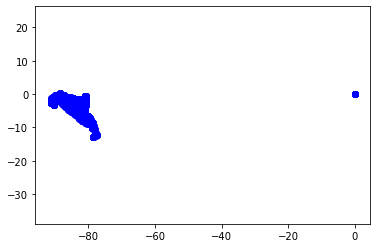

In [4]:
vp.plot(shp_lyr, 'bo')

There are some outliers far from the region of interest that we want to eliminate (it takes a long time, never used)

In [6]:
#shp_ds = ogr.Open(shp_fn, True)
#shp_lyr = shp_ds.GetLayer()
#shp_lyr.SetSpatialFilterRect(-1, -1, 1, 1)
#for shp_row in shp_lyr:
#    shp_lyr.DeleteFeature(shp_row.GetFID())
#    shp_lyr.SetSpatialFilter(None)
#    shp_ds.ExecuteSQL ('REPACK ' + shp_lyr.GetName())
#    shp_ds.ExecuteSQL ('RECOMPUTE EXTENT ON ' + shp_lyr.GetName())

The next step is to compute for each albastros the distances between the places in which it has been observed, in time order. 

In [ ]:
def get_unique(datasource, layer_name, field_name):
    sql = 'SELECT DISTINCT {0} FROM {1}'.format(field_name, layer_name)
    lyr = datasource.ExecuteSQL (sql)
    values = []
    for row in lyr:
        values.append(row.GetField(field_name))
    datasource.ReleaseResultSet(lyr)
    return values

For each bird it is possible to determine the areas that are mostly visited by computing the convex hull from the observations.

## Spatial reference systems
A spatial reference system consists of three elements

1. Coordinate system
2. Datum
3. Projection

A datum defines the shape of the Earth, sphere, ellipsoid, geoid. A (geographic) coordinate system is a reference system with the origin at the center of the Earth. An example of datum is the World Geodetic System 1984, or WGS84. The (geographic) coordinates of a point on the datum's surface can be projected on a 2D surface, a plane. There exist many projections that can be classified depending on the property that is preserved after a projection from 3D to 2D. Conformal projections preserve the angles. Universal Transverse Mercator (UTM) is a conformal projection. Equal-area projections preserve what is stated in its name, one example is the Lambert projection. The Azimuthal-equidistance projection preserves the distance. The spatial reference system must always be included with the data, otherwise it would be impossible to say to which location on Earth a coordinate pair refers to.

In [3]:
ds = ogr.Open(r'data\US\states_48.shp')
print(ds.GetLayer().GetSpatialRef())

GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101,
            AUTHORITY["EPSG","7019"]],
        AUTHORITY["EPSG","6269"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]


This reference system is not projected and it is called 'geographic' or 'unprojected'.

In [5]:
print(ds.GetLayer().GetSpatialRef().GetAttrValue('PROJCS'))

None


### Creating a spatial reference system
The [EPSG](https://epsg.io) has a list of spatial reference systems. We can use a spatial reference system to be used in a layer.

In [62]:
sr = osr.SpatialReference()
sr.ImportFromEPSG(26912)

0

In [63]:
sr.GetAttrValue('PROJCS')

'NAD83 / UTM zone 12N'

Once we have a spatial reference we can create a data source and a layer adding the spatial reference to it.

In [42]:
driver = ogr.GetDriverByName('ESRI Shapefile')
ds = driver.CreateDataSource(r'data\testdata.shp')
lyr = ds.CreateLayer('counties', sr, ogr.wkbPolygon)

We can add features to a layer, paying attention that their coordinates are valid according to the layer's spatial reference. In case a feauture has a different spatial reference than the layer, we have to transform its coordinates before adding that feature to the layer.

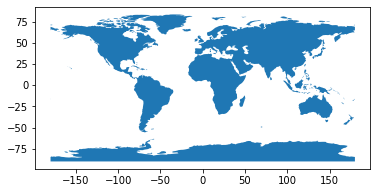

In [71]:
world_fn = r'data\Global\ne_110m_land_1p.shp'
world = pb.get_shp_geom(world_fn)
world = gdf.from_file(world_fn)
world.plot()
plt.show()

In [73]:
world_ds = ogr.Open(world_fn)
print(world_ds.GetLayer().GetSpatialRef())

GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]


We can create a feature, e.g. a point with its coordinate pair, and assign a spatial reference to it.

In [66]:
sr_wgs84 = osr.SpatialReference()
sr_wgs84.ImportFromEPSG(4326)

0

In [67]:
tower = ogr.Geometry(ogr.wkbPoint) 
tower.AddPoint(2.294694, 48.858093)
tower.AssignSpatialReference(sr_wgs84)

We can transform our point's coordinates to another reference system, e.g the one used by Google Maps [EPSG:3857](https://epsg.io/3857)

In [74]:
web_mercator_sr = osr.SpatialReference()
web_mercator_sr.ImportFromEPSG(3857)

0

In [75]:
tower.TransformTo(web_mercator_sr)
print(tower)

POINT (5438858.0338904 255512.483732941 0)


### Great circle calculation
We use [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) to compute the distance between two cities.

In [79]:
la_lat, la_lon = 34.0500, -118.2500
berlin_lat, berlin_lon = 52.5167, 13.3833
geod = pyproj.Geod(ellps='WGS84')
forward, back, dist = geod.inv(la_lon, la_lat, berlin_lon, berlin_lat)
print('forward: {}\nback: {}\ndist: {} km'.format(forward, back, dist / 1000))

forward: 27.23284045673669
back: -38.49148498662069
dist: 9331.934878166698 km
